In [743]:
# encoding=utf8 


In [744]:

import pandas as pd

data = pd.read_csv("data-verici.csv", encoding = 'utf8', decimal=",")
df1 = pd.Categorical(data[u'Nejvyšší dosažené vzdělání:'])
data['vzdelani'] = df1.codes
df2 = pd.Categorical(data[u'Pohlaví:'])
data['pohlavi'] = df2.codes
df2 = pd.Categorical(data[u'vira'], categories=["Ne", "Ano"])
data['vira_c'] = df2.codes
data.head()

,Časová značka,Pohlaví:,Věk:,Nejvyšší dosažené vzdělání:,Jste věřící?,V co věříte?,Unnamed: 6,Unnamed: 7,vira,"Pokud se hlásíte k některé církvi, uveďte prosím k jaké:",...,COS,EPD,EWB,PAR,REL,CELKEM,Unnamed: 121,vzdelani,pohlavi,vira_c
0,26.2.2018 13:26:35,Žena,19,ZŠ,Ano,"Nejsem věřící tak, že chodím do kostela, ale v...",něco mezi nebem a Zemí,A,Ano,NaN,...,13,14,15,21,10,73,NaN,4,1,1
1,24.2.2018 20:06:33,Žena,20,ZŠ,Ano,v učení katolické církve,v Boha,B,Ano,římskokatolická církev,...,20,21,14,7,23,85,NaN,4,1,1
2,22.2.2018 13:29:33,Žena,20,SŠ,Ano,V Boha,v Boha,B,Ano,Katolická,...,15,14,6,8,15,58,NaN,0,1,1
3,26.2.2018 12:52:27,Muž,21,VŠ - bakalářské,Ano,Boha,v Boha,B,Ano,Krestanstvo,...,18,5,19,6,12,60,robert.kolcun@gmail.com,2,0,1
4,26.2.2018 15:44:38,Žena,21,SŠ,Ano,v Boha,v Boha,B,Ano,Církev Adventistů sedmého dne,...,20,9,19,14,20,82,NaN,0,1,1


In [745]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import sqrt

mw_results = {}
pearson_results = {}

In [746]:
import numpy as np

def histogram(field, passed_data=None):
    print("\n--------------")
    if passed_data is None:
        local_data = data[field].astype(float)
    else:
        local_data = passed_data
    minim = local_data.min()
    maxim = local_data.max()
    print("Min: %f\nMax: %f" % (minim, maxim))
    loc, scale = stats.norm.fit(local_data)
    n = stats.norm(loc=loc, scale=scale)

    plt.hist(local_data, bins=30, rwidth=0.5)
    plt.show()
    
    results = {}
    shapiro = stats.shapiro(local_data)
    print("Shapiro:\n  W: %f\n  p-value: %f\n" % (shapiro[0], shapiro[1]))
    results['Shapiro'] = shapiro[0]

    ks_results = stats.kstest(local_data, n.cdf)
    print("Kolmogorov:\n  Statistics: %f\n  p-value: %f" % (ks_results[0], ks_results[1]))
    results['Kolmogorov'] = ks_results[0]
    print("--------------\n")

In [747]:
def pearson_sperman_lin_plot(a_name, b_name):
    a = data[a_name]
    b = data[b_name]
    plt.scatter(x=a, y=b)

    pearson = stats.pearsonr(a, b)
    print("Pearson:\n  PCC: %f\n  p-value: %f\n" % pearson)

    spearman = stats.spearmanr(a, b)
    print("Spearman:\n  Corr: %s\n  pvalue: %f\n" % spearman)

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(a, b)
    print("Slope: %f\n  Intercept: %f\n  rvalue: %f\n  pvalue: %f\n  stderr: %f\n" % (slope, intercept, rvalue, pvalue, stderr))

    lin_y = [slope * x + intercept for x in a]
    plt.plot(a, lin_y, color='red')
    plt.show()
    
    pearson_results[(a_name, b_name)] = {'r_s': spearman[0], 'p_s': spearman[1], 'r': pearson[0], 'p_p': pearson[1]}
    

In [748]:
def compute_z(u, xa, ya):
    m_u = len(xa)*len(ya)/2
    sigma_u = np.sqrt(len(xa)*len(ya)*(len(xa)+len(ya)+1)/12)
    z = (u - m_u)/sigma_u
    return z

def mw_ttest_lin_relig(what):
    x = data['vira_c']
    y = data[what]

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

    ano = data[data[u'vira'] == u'Ano']
    ne = data[data[u'vira'] == u'Ne']

    mw = stats.mannwhitneyu(ano[what], ne[what])
    xa = ano[what]
    print("Verici")
    histogram(None, passed_data=xa)
    ya = ne[what]
    print("Neverici")
    histogram(None, passed_data=ya)
    z = compute_z(mw[0], xa, ya)
    
    plt.scatter(x=x, y=y)
    
    print("Mann-Whitney:\n  Stat: %f\n  pvalue: %f\n  z: %f\n" % (mw[0], mw[1], z))

    ttest = stats.ttest_ind(ano[what], ne[what])
    print("t-test:\n  Stat: %f\n  pvalue: %f \n" % ttest)
    # Krizická hodnota t = 2.357 - hypotéza se zamítá
    d = ttest[0] * (xa.count() + ya.count()) / sqrt((y.count()-2) * xa.count() * ya.count())
    print("KOhen's d (ttest): %f\n" % d)
    
    d2 = (xa.mean() - ya.mean()) / sqrt((xa.var()+ya.var())/2)
    print("KOhen's d: %f\n" % d2)
    
    r = z / sqrt(data[u'vira'].count())
    print("Effect size r: %f\n" % r)

    y = [slope * x_val + intercept for x_val in x]
    plt.plot(x, y, color='red')
    plt.xticks([0, 1], [u'Ne', u'Ano'])
    plt.show()
    
    mw_results[what] = {'U': mw[0], 'z': z, 'p': mw[1], 'd': d2, 'r': r}



In [765]:
def mw_ttest_lin_sex(what):
    pohlavi = data['pohlavi']
    y = data[what]

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(pohlavi, y)

    muzi = data[data[u'Pohlaví:'] == u'Muž']
    zeny = data[data[u'Pohlaví:'] == u'Žena']
    
    print("Muzi")
    histogram(None, passed_data=muzi[what])
    print("Zeny")
    histogram(None, passed_data=zeny[what])
    
    plt.scatter(x=pohlavi, y=y)

    mw = stats.mannwhitneyu(muzi[what], zeny[what])
    print("Mann-Whitney:\n  Stat: %f\n  pvalue: %f\n  z: %f\n" % (mw[0], mw[1], compute_z(mw[0], muzi[what], zeny[what])))

    ttest = stats.ttest_ind(muzi[what], zeny[what])
    print("t-test:\n  Stat: %f\n  pvalue: %f \n" % ttest)
    # Krizická hodnota t = 2.357 - hypotéza se zamítá
    d = ttest[0] * (muzi[what].count() + zeny[what].count()) / sqrt((y.count()-2) * muzi[what].count() * zeny[what].count())
    print("KOhen's d (ttest): %f\n" % d)
    
    d2 = (muzi[what].mean() - zeny[what].mean()) / sqrt((muzi[what].var()+zeny[what].var())/2)
    print("KOhen's d: %f\n" % d2)
    
    z = compute_z(mw[0], muzi, zeny)
    r = z / sqrt(data[u'vira'].count())
    print("Effect size r: %f\n" % r)

    y = [slope * x + intercept for x in pohlavi]
    plt.plot(pohlavi, y, color='red')
    plt.xticks([0, 1], [u'Muž', u'Žena'])
    plt.show()


# SCS


--------------
Min: 20.000000
Max: 89.000000


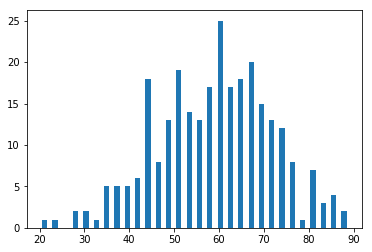

Shapiro:
  W: 0.994261
  p-value: 0.385880

Kolmogorov:
  Statistics: 0.062420
  p-value: 0.225017
--------------



In [766]:
histogram(u'součet')

# DAP-R


--------------
Min: 1.000000
Max: 7.000000


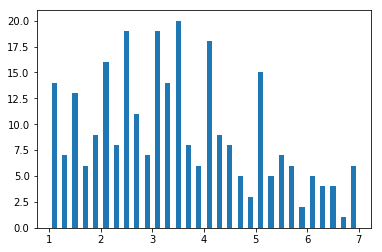

Shapiro:
  W: 0.968727
  p-value: 0.000011

Kolmogorov:
  Statistics: 0.080983
  p-value: 0.051287
--------------



In [767]:
histogram('FD')


--------------
Min: 1.000000
Max: 7.000000


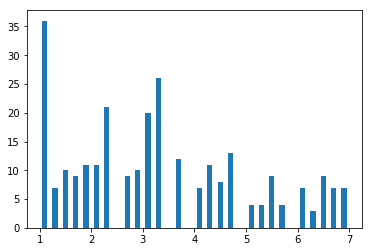

Shapiro:
  W: 0.934064
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.097198
  p-value: 0.010310
--------------



In [768]:
histogram('DA')


--------------
Min: 1.200000
Max: 7.000000


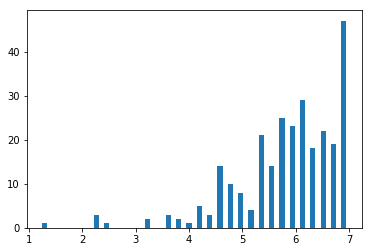

Shapiro:
  W: 0.882128
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.135880
  p-value: 0.000069
--------------



In [769]:
histogram('NA')


--------------
Min: 1.000000
Max: 7.000000


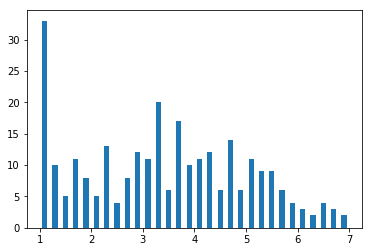

Shapiro:
  W: 0.962642
  p-value: 0.000002

Kolmogorov:
  Statistics: 0.070387
  p-value: 0.124994
--------------



In [770]:
histogram('AA')


--------------
Min: 1.000000
Max: 7.000000


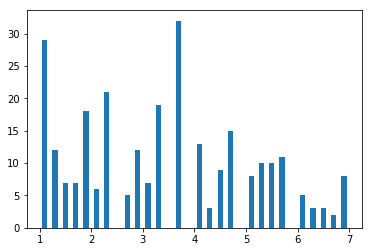

Shapiro:
  W: 0.952294
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.089420
  p-value: 0.023083
--------------



In [771]:
histogram('EA')

# ESI


--------------
Min: 0.000000
Max: 24.000000


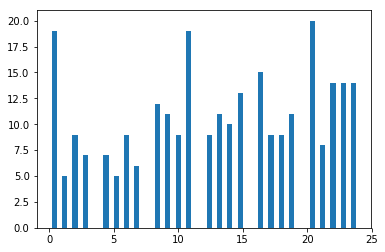

Shapiro:
  W: 0.947277
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.090085
  p-value: 0.021603
--------------



In [772]:
histogram('COS')


--------------
Min: 0.000000
Max: 24.000000


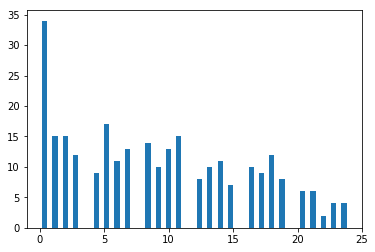

Shapiro:
  W: 0.941738
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.096354
  p-value: 0.011288
--------------



In [773]:
histogram('EPD')


--------------
Min: 0.000000
Max: 24.000000


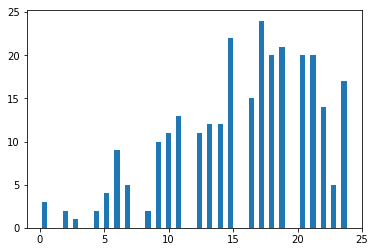

Shapiro:
  W: 0.959090
  p-value: 0.000001

Kolmogorov:
  Statistics: 0.105308
  p-value: 0.004141
--------------



In [774]:
histogram('EWB')


--------------
Min: 0.000000
Max: 24.000000


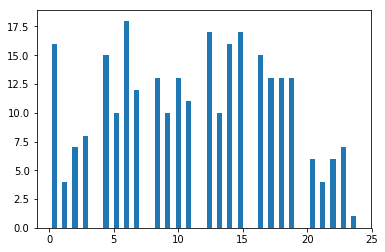

Shapiro:
  W: 0.970139
  p-value: 0.000017

Kolmogorov:
  Statistics: 0.078583
  p-value: 0.063442
--------------



In [775]:
histogram('PAR')


--------------
Min: 0.000000
Max: 24.000000


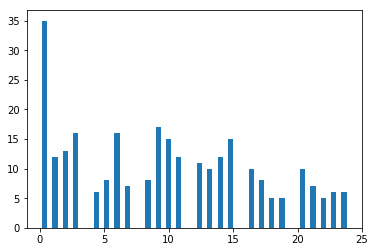

Shapiro:
  W: 0.944238
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.104478
  p-value: 0.004561
--------------



In [776]:
histogram('REL')


--------------
Min: 7.000000
Max: 108.000000


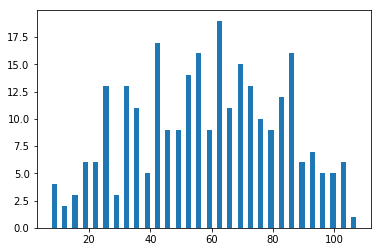

Shapiro:
  W: 0.982637
  p-value: 0.002003

Kolmogorov:
  Statistics: 0.050076
  p-value: 0.487207
--------------



In [777]:
histogram('CELKEM')

In [778]:
c = [str(x) for x in data[u'součet']]
with open("soucet.csv", "w") as fp:
    fp.write("\n".join(c))
#data['součet'].to_csv('soucet.csv')

# SCS correlations

Pearson:
  PCC: 0.135153
  p-value: 0.025004

Spearman:
  Corr: 0.1455046389081874
  pvalue: 0.015744

Slope: 0.208680
  Intercept: 52.793838
  rvalue: 0.135153
  pvalue: 0.025004
  stderr: 0.092592



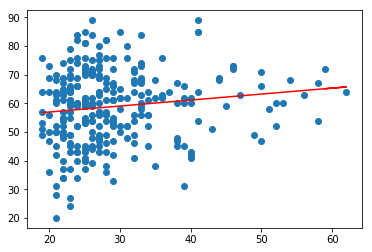

In [779]:
#Věk vs. Součet
pearson_sperman_lin_plot(u'Věk:', u'součet')

Muzi

--------------
Min: 37.000000
Max: 89.000000


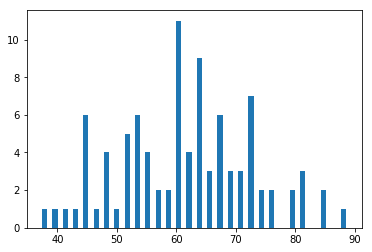

Shapiro:
  W: 0.990759
  p-value: 0.767651

Kolmogorov:
  Statistics: 0.064057
  p-value: 0.839957
--------------

Zeny

--------------
Min: 20.000000
Max: 89.000000


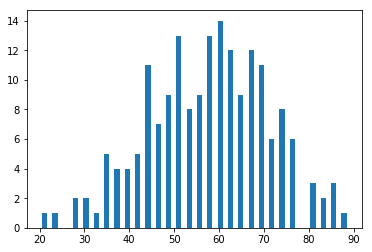

Shapiro:
  W: 0.993957
  p-value: 0.664575

Kolmogorov:
  Statistics: 0.062888
  p-value: 0.454812
--------------

Mann-Whitney:
  Stat: 6990.500000
  pvalue: 0.009133
  z: -2.360012

t-test:
  Stat: 2.609385
  pvalue: 0.009571 

KOhen's d (ttest): 0.333820

KOhen's d: 0.342287

Effect size r: -0.142314



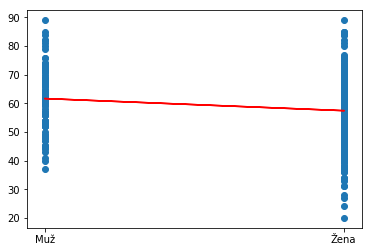

In [780]:
#Pohlaví vs. Součet

mw_ttest_lin_sex(u'součet')

Verici

--------------
Min: 20.000000
Max: 89.000000


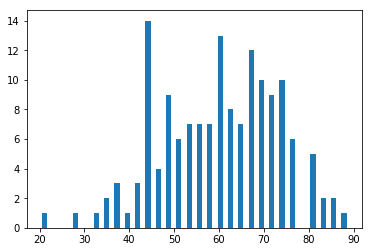

Shapiro:
  W: 0.987243
  p-value: 0.181775

Kolmogorov:
  Statistics: 0.066320
  p-value: 0.507267
--------------

Neverici

--------------
Min: 24.000000
Max: 89.000000


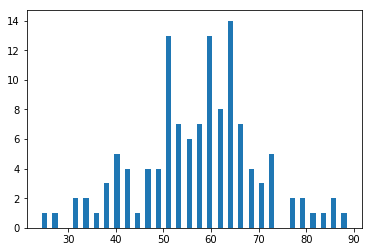

Shapiro:
  W: 0.989845
  p-value: 0.495784

Kolmogorov:
  Statistics: 0.064982
  p-value: 0.672651
--------------

Mann-Whitney:
  Stat: 8190.500000
  pvalue: 0.037119
  z: -1.785168

t-test:
  Stat: 1.644792
  pvalue: 0.101164 

KOhen's d (ttest): 0.200061

KOhen's d: 0.199866

Effect size r: -0.107650



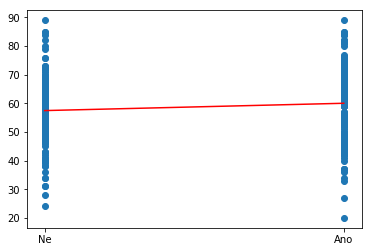

In [781]:
#Víra vs. Součet

mw_ttest_lin_relig(u'součet')

Nejvyšší dosažené vzdělání:
SŠ                          36
VOŠ                          5
VŠ - bakalářské             45
VŠ - magisterské a vyšší    99
ZŠ                           3
dtype: int64

ANOVA
Statistics: 0.306781
pvalue: 0.873187

pvalue > 0.05 - přijímáme hypotézu - nemá vliv


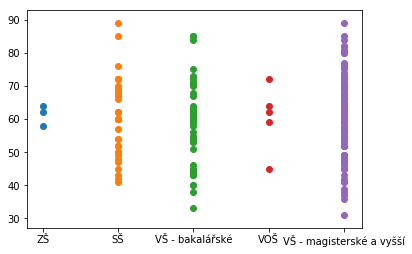

In [782]:
#OD 25
print("%s\n" % data[data[u'Věk:'] >= 25].groupby(u'Nejvyšší dosažené vzdělání:').size())
vzdelani = data[data[u'Věk:'] >= 25].groupby(u'Nejvyšší dosažené vzdělání:')

result = []
for g in vzdelani.groups:
    result.append(data[u'součet'][vzdelani.groups[g]])

anova = stats.f_oneway(*result)
print("ANOVA\nStatistics: %f\npvalue: %f\n" % anova)
print("pvalue > 0.05 - přijímáme hypotézu - nemá vliv")

i = 0
for g in result:
    plt.scatter([i]*len(g), g)
    i += 1
    
plt.xticks(range(0, len(result)), data.groupby(u'Nejvyšší dosažené vzdělání:').groups.keys())
plt.show()

In [841]:
#OD 25
print("%s\n" % data[data[u'Věk:'] >= 25].groupby(u'Nejvyšší dosažené vzdělání:').size())
vzdelani = data[data[u'Věk:'] >= 25].groupby(u'Nejvyšší dosažené vzdělání:')

result = []
for g in vzdelani.groups:
    result.append(data[u'součet'][vzdelani.groups[g]])

kruskal = stats.kruskal(*result)

print("Kruskal\nStatistics: %f\npvalue: %f\n" % kruskal)
print("pvalue > 0.05 - přijímáme hypotézu - nemá vliv")

Nejvyšší dosažené vzdělání:
SŠ                          36
VOŠ                          5
VŠ - bakalářské             45
VŠ - magisterské a vyšší    99
ZŠ                           3
dtype: int64

Kruskal
Statistics: 1.525134
pvalue: 0.822180

pvalue > 0.05 - přijímáme hypotézu - nemá vliv


# DAP-R correlations

Pearson:
  PCC: -0.140322
  p-value: 0.019917

Spearman:
  Corr: -0.17901124249860426
  pvalue: 0.002891

Slope: -0.025571
  Intercept: 4.197420
  rvalue: -0.140322
  pvalue: 0.019917
  stderr: 0.010920



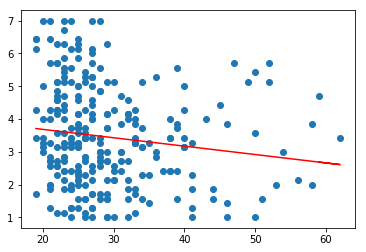

In [783]:
#Věk vs. FD
pearson_sperman_lin_plot(u'Věk:', u'FD')

Pearson:
  PCC: -0.002452
  p-value: 0.967717

Spearman:
  Corr: -0.04045948283182688
  pvalue: 0.504030

Slope: -0.000520
  Intercept: 3.300961
  rvalue: -0.002452
  pvalue: 0.967717
  stderr: 0.012840



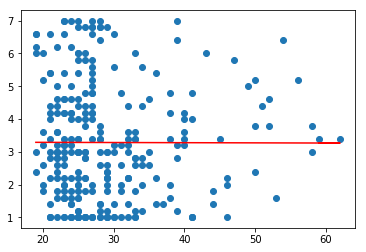

In [784]:
#Věk vs DA
pearson_sperman_lin_plot(u'Věk:', 'DA')

Muzi

--------------
Min: 1.000000
Max: 7.000000


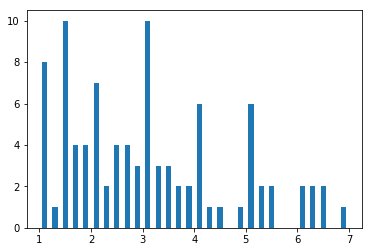

Shapiro:
  W: 0.935924
  p-value: 0.000195

Kolmogorov:
  Statistics: 0.102580
  p-value: 0.263821
--------------

Zeny

--------------
Min: 1.000000
Max: 7.000000


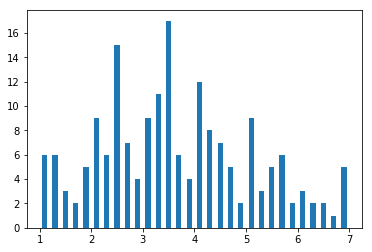

Shapiro:
  W: 0.977019
  p-value: 0.004223

Kolmogorov:
  Statistics: 0.077147
  p-value: 0.217629
--------------

Mann-Whitney:
  Stat: 6561.000000
  pvalue: 0.001147
  z: -3.048382

t-test:
  Stat: -2.770901
  pvalue: 0.005974 

KOhen's d (ttest): -0.354483

KOhen's d: -0.350049

Effect size r: -0.183824



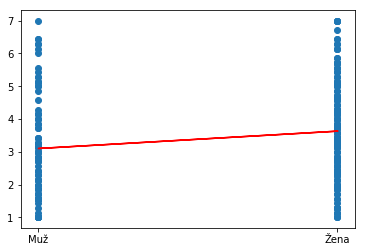

In [785]:
#Pohlaví vs FD

mw_ttest_lin_sex('FD')

Muzi

--------------
Min: 1.000000
Max: 7.000000


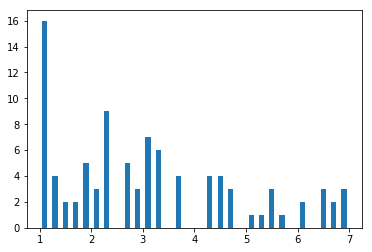

Shapiro:
  W: 0.911753
  p-value: 0.000010

Kolmogorov:
  Statistics: 0.121448
  p-value: 0.118363
--------------

Zeny

--------------
Min: 1.000000
Max: 7.000000


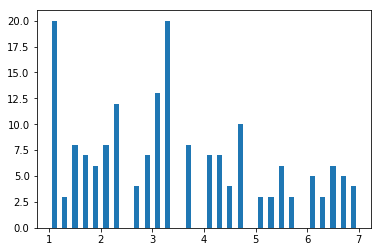

Shapiro:
  W: 0.942838
  p-value: 0.000001

Kolmogorov:
  Statistics: 0.092727
  p-value: 0.082024
--------------

Mann-Whitney:
  Stat: 7514.500000
  pvalue: 0.063991
  z: -1.520184

t-test:
  Stat: -1.344109
  pvalue: 0.180029 

KOhen's d (ttest): -0.171953

KOhen's d: -0.170723

Effect size r: -0.091671



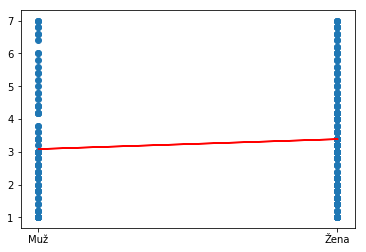

In [786]:
mw_ttest_lin_sex('DA')

Muzi

--------------
Min: 2.200000
Max: 7.000000


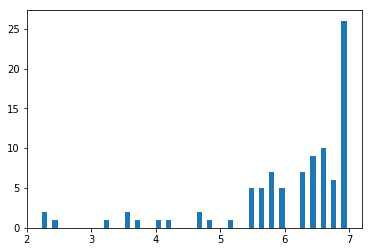

Shapiro:
  W: 0.782770
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.201549
  p-value: 0.000868
--------------

Zeny

--------------
Min: 1.200000
Max: 7.000000


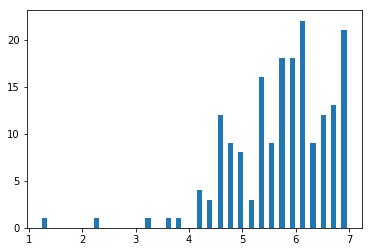

Shapiro:
  W: 0.912123
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.120411
  p-value: 0.009319
--------------

Mann-Whitney:
  Stat: 6378.000000
  pvalue: 0.000394
  z: -3.341681

t-test:
  Stat: 2.036346
  pvalue: 0.042681 

KOhen's d (ttest): 0.260511

KOhen's d: 0.251796

Effect size r: -0.201511



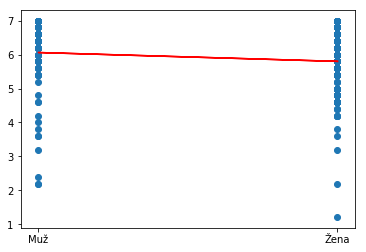

In [787]:
mw_ttest_lin_sex('NA')

Muzi

--------------
Min: 1.000000
Max: 7.000000


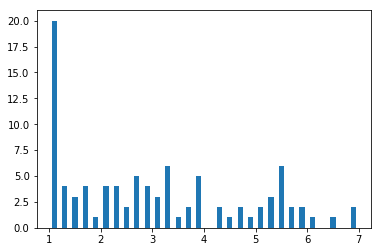

Shapiro:
  W: 0.911008
  p-value: 0.000010

Kolmogorov:
  Statistics: 0.124610
  p-value: 0.102135
--------------

Zeny

--------------
Min: 1.000000
Max: 6.800000


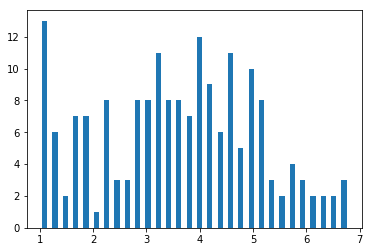

Shapiro:
  W: 0.976020
  p-value: 0.003155

Kolmogorov:
  Statistics: 0.065786
  p-value: 0.396275
--------------

Mann-Whitney:
  Stat: 6558.000000
  pvalue: 0.001127
  z: -3.053190

t-test:
  Stat: -2.865491
  pvalue: 0.004487 

KOhen's d (ttest): -0.366584

KOhen's d: -0.355214

Effect size r: -0.184114



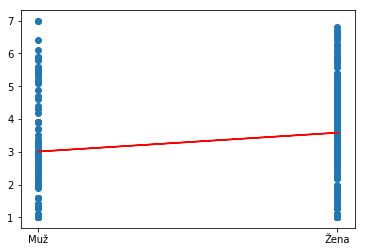

In [788]:
mw_ttest_lin_sex('AA')

Muzi

--------------
Min: 1.000000
Max: 7.000000


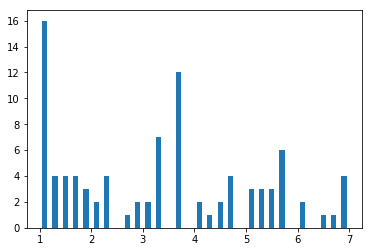

Shapiro:
  W: 0.921200
  p-value: 0.000031

Kolmogorov:
  Statistics: 0.123948
  p-value: 0.105372
--------------

Zeny

--------------
Min: 1.000000
Max: 7.000000


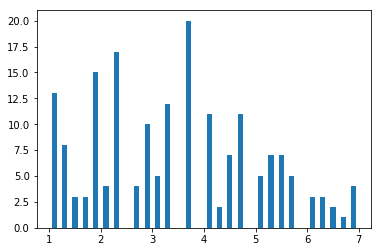

Shapiro:
  W: 0.963632
  p-value: 0.000114

Kolmogorov:
  Statistics: 0.082359
  p-value: 0.160166
--------------

Mann-Whitney:
  Stat: 7967.000000
  pvalue: 0.213238
  z: -0.794951

t-test:
  Stat: -0.493685
  pvalue: 0.621926 

KOhen's d (ttest): -0.063157

KOhen's d: -0.061337

Effect size r: -0.047937



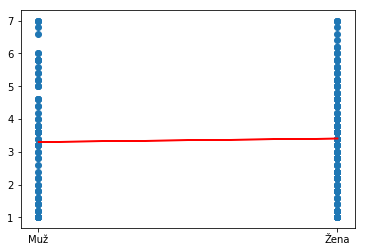

In [789]:
mw_ttest_lin_sex('EA')

Verici

--------------
Min: 1.000000
Max: 7.000000


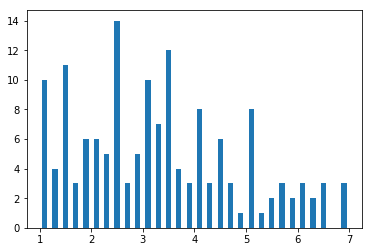

Shapiro:
  W: 0.959406
  p-value: 0.000205

Kolmogorov:
  Statistics: 0.078896
  p-value: 0.289631
--------------

Neverici

--------------
Min: 1.000000
Max: 7.000000


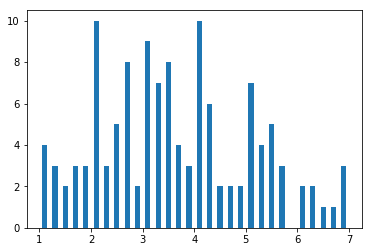

Shapiro:
  W: 0.974935
  p-value: 0.020764

Kolmogorov:
  Statistics: 0.085853
  p-value: 0.303664
--------------

Mann-Whitney:
  Stat: 8153.000000
  pvalue: 0.032700
  z: -1.842312

t-test:
  Stat: -1.717148
  pvalue: 0.087086 

KOhen's d (ttest): -0.208862

KOhen's d: -0.208623

Effect size r: -0.111096



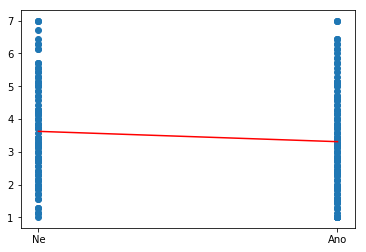

In [790]:
mw_ttest_lin_relig('FD')

Verici

--------------
Min: 1.000000
Max: 7.000000


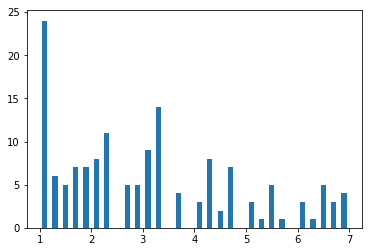

Shapiro:
  W: 0.914351
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.120318
  p-value: 0.023123
--------------

Neverici

--------------
Min: 1.000000
Max: 7.000000


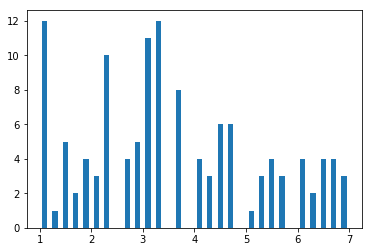

Shapiro:
  W: 0.950884
  p-value: 0.000194

Kolmogorov:
  Statistics: 0.095382
  p-value: 0.196457
--------------

Mann-Whitney:
  Stat: 7795.000000
  pvalue: 0.008393
  z: -2.387843

t-test:
  Stat: -2.224363
  pvalue: 0.026942 

KOhen's d (ttest): -0.270556

KOhen's d: -0.269835

Effect size r: -0.143992



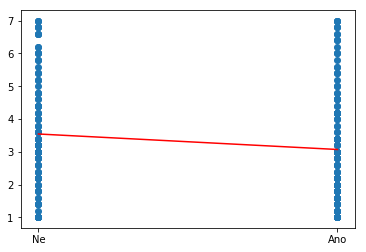

In [791]:
mw_ttest_lin_relig('DA')

Verici

--------------
Min: 1.200000
Max: 7.000000


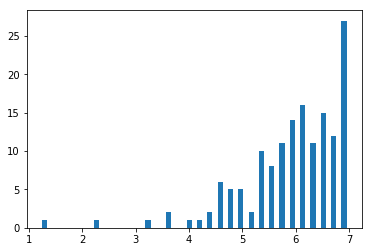

Shapiro:
  W: 0.859719
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.147584
  p-value: 0.002463
--------------

Neverici

--------------
Min: 2.200000
Max: 7.000000


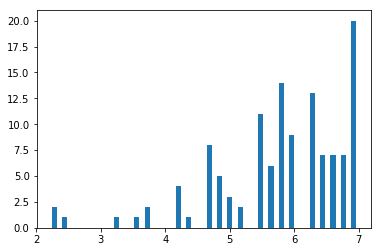

Shapiro:
  W: 0.903170
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.130812
  p-value: 0.026075
--------------

Mann-Whitney:
  Stat: 8192.500000
  pvalue: 0.036743
  z: -1.782120

t-test:
  Stat: 1.717065
  pvalue: 0.087101 

KOhen's d (ttest): 0.208852

KOhen's d: 0.207315

Effect size r: -0.107466



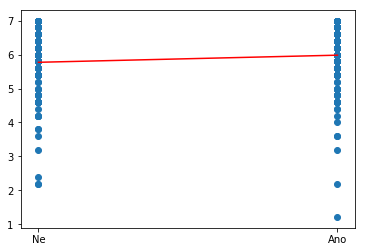

In [792]:
mw_ttest_lin_relig('NA')

Verici

--------------
Min: 1.000000
Max: 7.000000


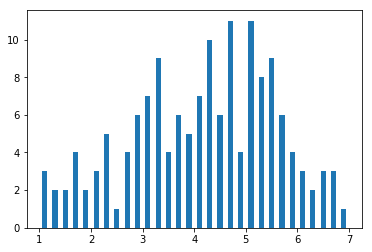

Shapiro:
  W: 0.980930
  p-value: 0.034345

Kolmogorov:
  Statistics: 0.064242
  p-value: 0.551351
--------------

Neverici

--------------
Min: 1.000000
Max: 7.000000


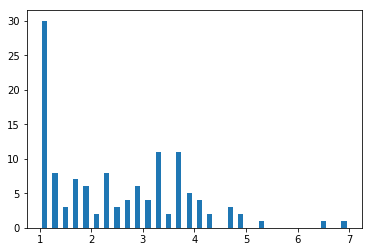

Shapiro:
  W: 0.910172
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.127609
  p-value: 0.032124
--------------

Mann-Whitney:
  Stat: 3668.000000
  pvalue: 0.000000
  z: -8.676693

t-test:
  Stat: 9.927973
  pvalue: 0.000000 

KOhen's d (ttest): 1.207571

KOhen's d: 1.207724

Effect size r: -0.523224



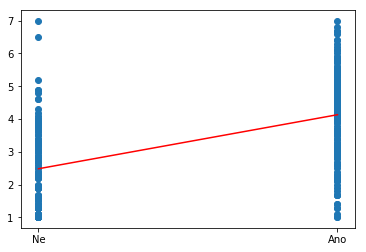

In [793]:
mw_ttest_lin_relig('AA')

Verici

--------------
Min: 1.000000
Max: 7.000000


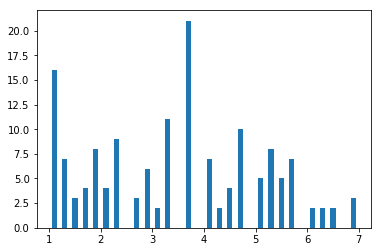

Shapiro:
  W: 0.955463
  p-value: 0.000091

Kolmogorov:
  Statistics: 0.088517
  p-value: 0.176781
--------------

Neverici

--------------
Min: 1.000000
Max: 7.000000


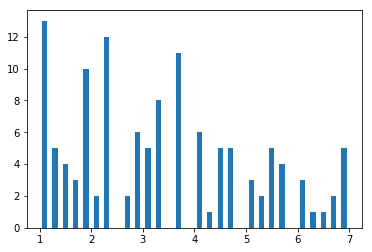

Shapiro:
  W: 0.940728
  p-value: 0.000036

Kolmogorov:
  Statistics: 0.096132
  p-value: 0.189473
--------------

Mann-Whitney:
  Stat: 8915.000000
  pvalue: 0.247834
  z: -0.681152

t-test:
  Stat: 0.506642
  pvalue: 0.612815 

KOhen's d (ttest): 0.061624

KOhen's d: 0.061244

Effect size r: -0.041075



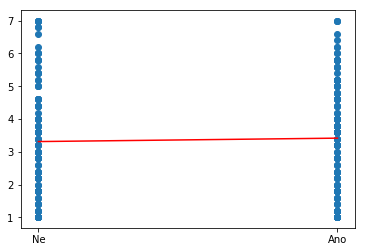

In [794]:
mw_ttest_lin_relig('EA')

Pearson:
  PCC: 0.043383
  p-value: 0.473692

Spearman:
  Corr: 0.07488386621123355
  pvalue: 0.215757

Slope: 0.038056
  Intercept: 11.877534
  rvalue: 0.043383
  pvalue: 0.473692
  stderr: 0.053042



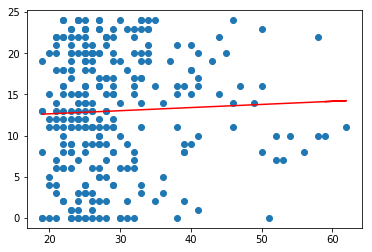

In [795]:
#Věk vs COS

pearson_sperman_lin_plot(u'Věk:', 'COS')

Pearson:
  PCC: 0.059596
  p-value: 0.324787

Spearman:
  Corr: 0.049941615603346506
  pvalue: 0.409411

Slope: 0.049014
  Intercept: 7.663980
  rvalue: 0.059596
  pvalue: 0.324787
  stderr: 0.049687



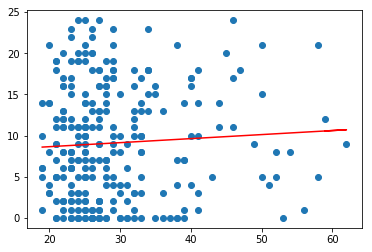

In [796]:
#Věk vs EPD

pearson_sperman_lin_plot(u'Věk:', 'EPD')

Pearson:
  PCC: 0.117625
  p-value: 0.051359

Spearman:
  Corr: 0.16867473194301688
  pvalue: 0.005039

Slope: 0.076552
  Intercept: 13.505917
  rvalue: 0.117625
  pvalue: 0.051359
  stderr: 0.039116



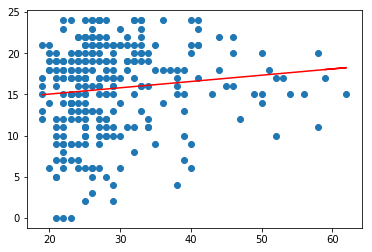

In [797]:
#Věk vs EWB

pearson_sperman_lin_plot(u'Věk:', 'EWB')

Pearson:
  PCC: 0.031214
  p-value: 0.606281

Spearman:
  Corr: 0.02798507940779088
  pvalue: 0.644041

Slope: 0.023658
  Intercept: 10.456714
  rvalue: 0.031214
  pvalue: 0.606281
  stderr: 0.045849



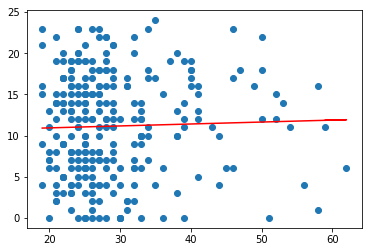

In [798]:
#Věk vs PAR

pearson_sperman_lin_plot(u'Věk:', 'PAR')

Pearson:
  PCC: -0.001476
  p-value: 0.980561

Spearman:
  Corr: 0.01921273347633576
  pvalue: 0.751103

Slope: -0.001259
  Intercept: 9.742110
  rvalue: -0.001476
  pvalue: 0.980561
  stderr: 0.051629



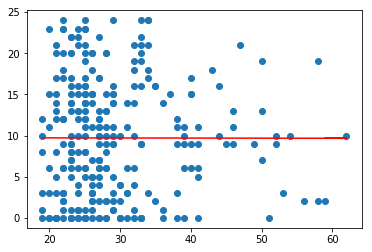

In [799]:
#Věk vs REL

pearson_sperman_lin_plot(u'Věk:', 'REL')

Pearson:
  PCC: 0.065498
  p-value: 0.279088

Spearman:
  Corr: 0.09199542663372366
  pvalue: 0.128046

Slope: 0.186020
  Intercept: 53.246256
  rvalue: 0.065498
  pvalue: 0.279088
  stderr: 0.171522



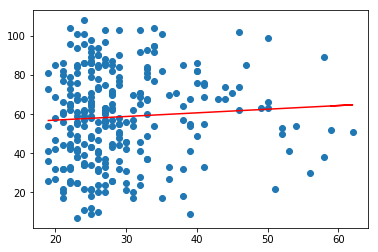

In [800]:
pearson_sperman_lin_plot(u'Věk:', 'CELKEM')

Muzi

--------------
Min: 0.000000
Max: 24.000000


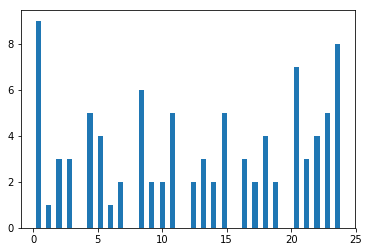

Shapiro:
  W: 0.925111
  p-value: 0.000050

Kolmogorov:
  Statistics: 0.113515
  p-value: 0.168535
--------------

Zeny

--------------
Min: 0.000000
Max: 24.000000


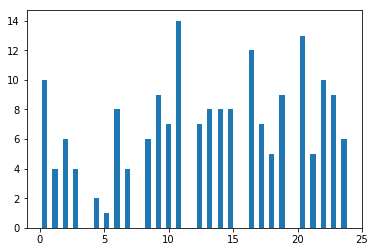

Shapiro:
  W: 0.954288
  p-value: 0.000013

Kolmogorov:
  Statistics: 0.086330
  p-value: 0.125113
--------------

Mann-Whitney:
  Stat: 8206.500000
  pvalue: 0.340620
  z: -0.411099

t-test:
  Stat: -0.604551
  pvalue: 0.545979 

KOhen's d (ttest): -0.077341

KOhen's d: -0.075219

Effect size r: -0.024790



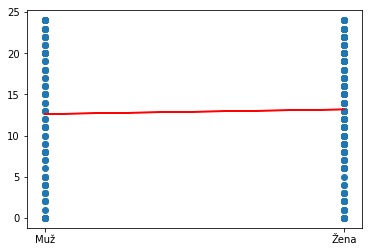

In [801]:
#Pohlaví vs COS

mw_ttest_lin_sex('COS')

Muzi

--------------
Min: 0.000000
Max: 24.000000


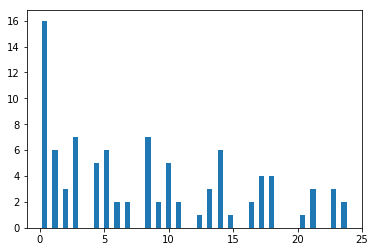

Shapiro:
  W: 0.910392
  p-value: 0.000009

Kolmogorov:
  Statistics: 0.141772
  p-value: 0.042932
--------------

Zeny

--------------
Min: 0.000000
Max: 24.000000


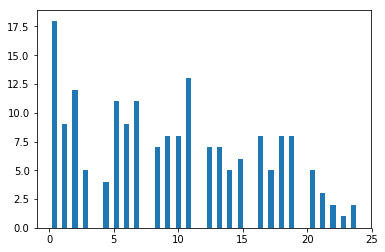

Shapiro:
  W: 0.952075
  p-value: 0.000008

Kolmogorov:
  Statistics: 0.085345
  p-value: 0.133161
--------------

Mann-Whitney:
  Stat: 7495.500000
  pvalue: 0.060261
  z: -1.550636

t-test:
  Stat: -1.276955
  pvalue: 0.202703 

KOhen's d (ttest): -0.163362

KOhen's d: -0.160380

Effect size r: -0.093507



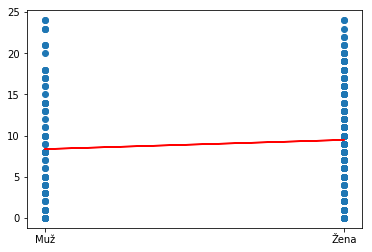

In [802]:
#Pohlaví vs EPD

mw_ttest_lin_sex('EPD')

Muzi

--------------
Min: 2.000000
Max: 24.000000


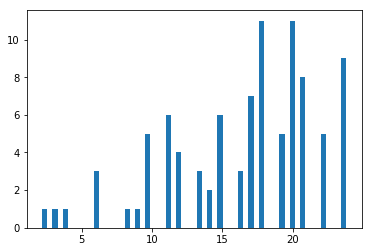

Shapiro:
  W: 0.942180
  p-value: 0.000450

Kolmogorov:
  Statistics: 0.136468
  p-value: 0.056794
--------------

Zeny

--------------
Min: 0.000000
Max: 24.000000


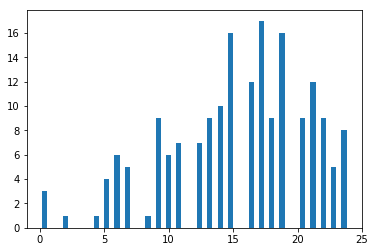

Shapiro:
  W: 0.963257
  p-value: 0.000104

Kolmogorov:
  Statistics: 0.097508
  p-value: 0.058663
--------------

Mann-Whitney:
  Stat: 7285.500000
  pvalue: 0.029379
  z: -1.887208

t-test:
  Stat: 1.789277
  pvalue: 0.074679 

KOhen's d (ttest): 0.228903

KOhen's d: 0.229312

Effect size r: -0.113803



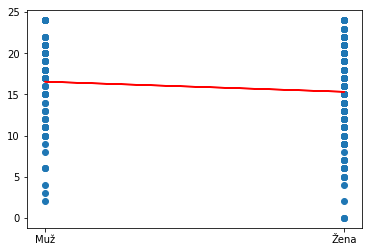

In [803]:
#Pohlaví vs EWB

mw_ttest_lin_sex('EWB')

Muzi

--------------
Min: 0.000000
Max: 24.000000


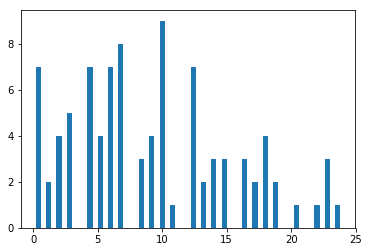

Shapiro:
  W: 0.955625
  p-value: 0.003113

Kolmogorov:
  Statistics: 0.111611
  p-value: 0.182801
--------------

Zeny

--------------
Min: 0.000000
Max: 23.000000


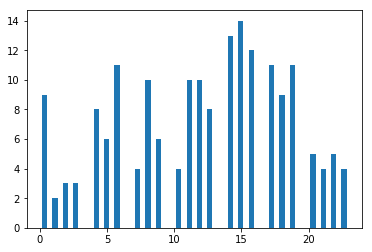

Shapiro:
  W: 0.965043
  p-value: 0.000163

Kolmogorov:
  Statistics: 0.103541
  p-value: 0.037516
--------------

Mann-Whitney:
  Stat: 6105.000000
  pvalue: 0.000078
  z: -3.779225

t-test:
  Stat: -3.735245
  pvalue: 0.000228 

KOhen's d (ttest): -0.477852

KOhen's d: -0.474351

Effect size r: -0.227896



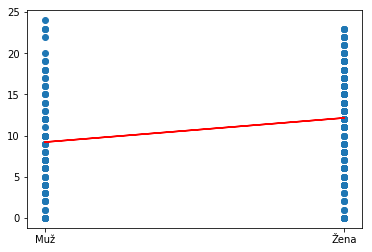

In [804]:
#Pohlaví vs PAR

mw_ttest_lin_sex('PAR')

Muzi

--------------
Min: 0.000000
Max: 24.000000


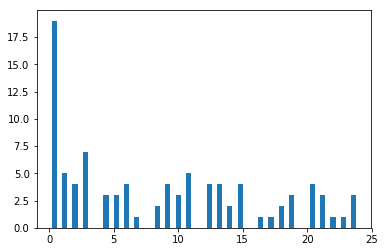

Shapiro:
  W: 0.902400
  p-value: 0.000004

Kolmogorov:
  Statistics: 0.148460
  p-value: 0.029709
--------------

Zeny

--------------
Min: 0.000000
Max: 24.000000


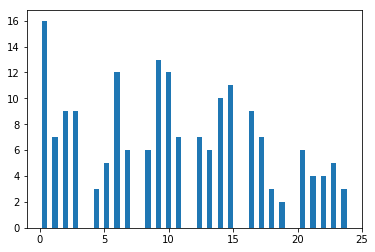

Shapiro:
  W: 0.959495
  p-value: 0.000042

Kolmogorov:
  Statistics: 0.083479
  p-value: 0.149564
--------------

Mann-Whitney:
  Stat: 7212.500000
  pvalue: 0.022367
  z: -2.004207

t-test:
  Stat: -1.796598
  pvalue: 0.073505 

KOhen's d (ttest): -0.229840

KOhen's d: -0.224755

Effect size r: -0.120858



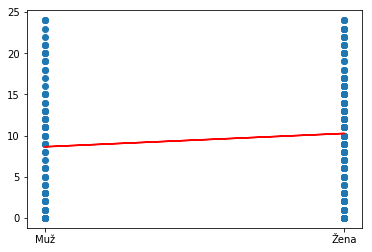

In [805]:
#Pohlaví vs REL

mw_ttest_lin_sex('REL')

Muzi

--------------
Min: 12.000000
Max: 103.000000


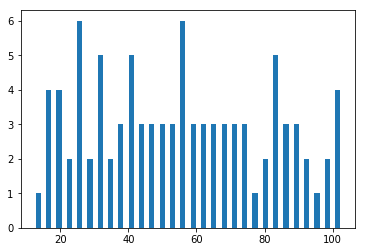

Shapiro:
  W: 0.959487
  p-value: 0.005632

Kolmogorov:
  Statistics: 0.073111
  p-value: 0.705663
--------------

Zeny

--------------
Min: 7.000000
Max: 108.000000


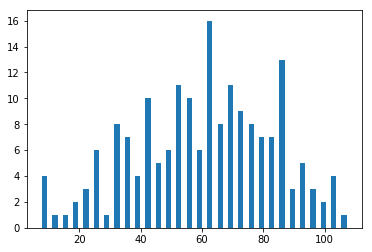

Shapiro:
  W: 0.986735
  p-value: 0.084503

Kolmogorov:
  Statistics: 0.044398
  p-value: 0.865650
--------------

Mann-Whitney:
  Stat: 7391.500000
  pvalue: 0.043014
  z: -1.717319

t-test:
  Stat: -1.664763
  pvalue: 0.097107 

KOhen's d (ttest): -0.212974

KOhen's d: -0.208605

Effect size r: -0.103558



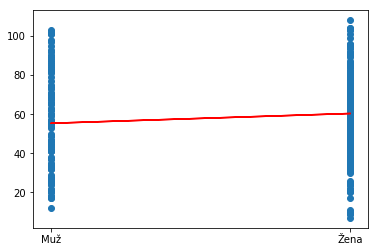

In [806]:
mw_ttest_lin_sex('CELKEM')

Verici

--------------
Min: 0.000000
Max: 24.000000


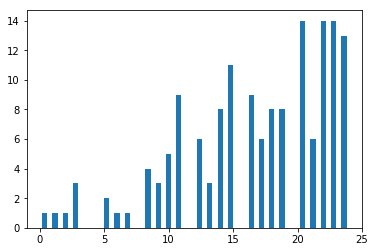

Shapiro:
  W: 0.931856
  p-value: 0.000001

Kolmogorov:
  Statistics: 0.120815
  p-value: 0.022290
--------------

Neverici

--------------
Min: 0.000000
Max: 24.000000


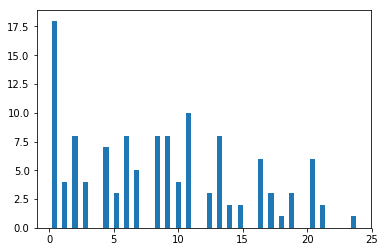

Shapiro:
  W: 0.945071
  p-value: 0.000073

Kolmogorov:
  Statistics: 0.090571
  p-value: 0.246157
--------------

Mann-Whitney:
  Stat: 3270.000000
  pvalue: 0.000000
  z: -9.283178

t-test:
  Stat: 11.229185
  pvalue: 0.000000 

KOhen's d (ttest): 1.365841

KOhen's d: 1.354523

Effect size r: -0.559797



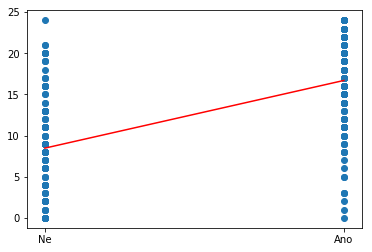

In [807]:
mw_ttest_lin_relig('COS')

Verici

--------------
Min: 0.000000
Max: 24.000000


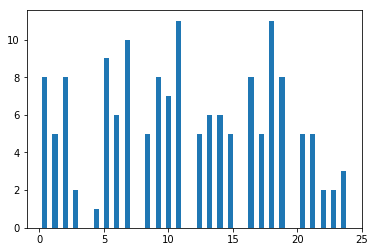

Shapiro:
  W: 0.964826
  p-value: 0.000666

Kolmogorov:
  Statistics: 0.085335
  p-value: 0.209432
--------------

Neverici

--------------
Min: 0.000000
Max: 24.000000


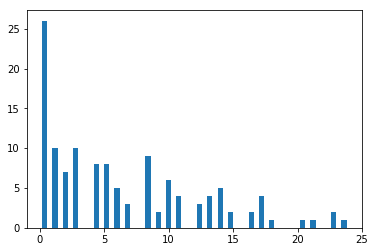

Shapiro:
  W: 0.889696
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.148452
  p-value: 0.007529
--------------

Mann-Whitney:
  Stat: 5319.000000
  pvalue: 0.000000
  z: -6.160848

t-test:
  Stat: 6.438839
  pvalue: 0.000000 

KOhen's d (ttest): 0.783176

KOhen's d: 0.783232

Effect size r: -0.371513



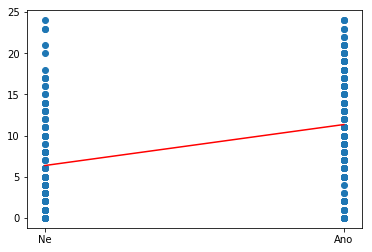

In [808]:
mw_ttest_lin_relig('EPD')

Verici

--------------
Min: 0.000000
Max: 24.000000


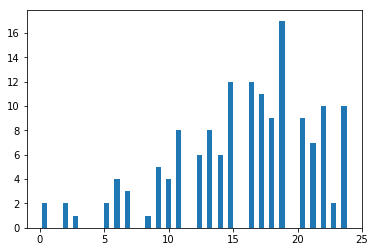

Shapiro:
  W: 0.956206
  p-value: 0.000105

Kolmogorov:
  Statistics: 0.099678
  p-value: 0.092897
--------------

Neverici

--------------
Min: 0.000000
Max: 24.000000


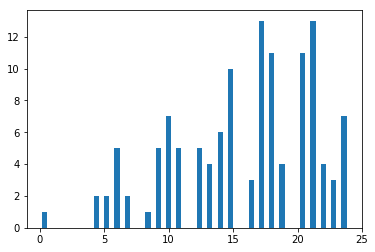

Shapiro:
  W: 0.957586
  p-value: 0.000644

Kolmogorov:
  Statistics: 0.127392
  p-value: 0.032575
--------------

Mann-Whitney:
  Stat: 9302.000000
  pvalue: 0.463810
  z: -0.091430

t-test:
  Stat: 0.091255
  pvalue: 0.927357 

KOhen's d (ttest): 0.011100

KOhen's d: 0.011061

Effect size r: -0.005513



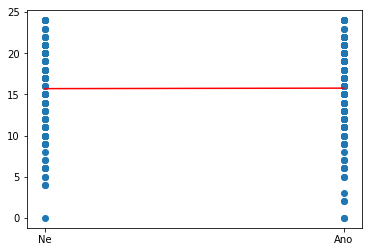

In [809]:
mw_ttest_lin_relig('EWB')

Verici

--------------
Min: 0.000000
Max: 24.000000


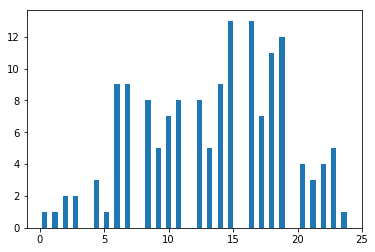

Shapiro:
  W: 0.975998
  p-value: 0.009588

Kolmogorov:
  Statistics: 0.101418
  p-value: 0.083455
--------------

Neverici

--------------
Min: 0.000000
Max: 23.000000


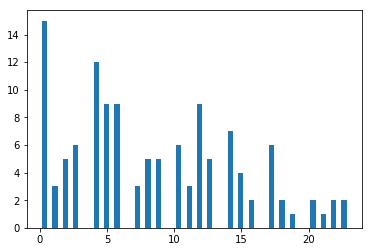

Shapiro:
  W: 0.947226
  p-value: 0.000104

Kolmogorov:
  Statistics: 0.130092
  p-value: 0.027339
--------------

Mann-Whitney:
  Stat: 5127.500000
  pvalue: 0.000000
  z: -6.452662

t-test:
  Stat: 6.954060
  pvalue: 0.000000 

KOhen's d (ttest): 0.845844

KOhen's d: 0.837691

Effect size r: -0.389110



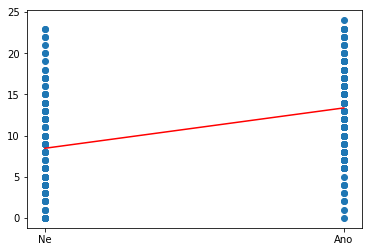

In [810]:
mw_ttest_lin_relig('PAR')

Verici

--------------
Min: 0.000000
Max: 24.000000


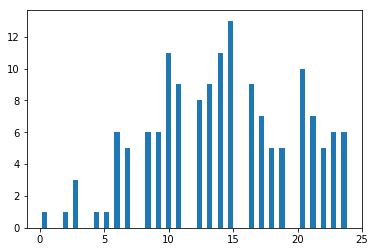

Shapiro:
  W: 0.980001
  p-value: 0.026910

Kolmogorov:
  Statistics: 0.076777
  p-value: 0.320452
--------------

Neverici

--------------
Min: 0.000000
Max: 17.000000


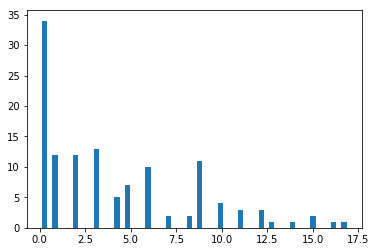

Shapiro:
  W: 0.865890
  p-value: 0.000000

Kolmogorov:
  Statistics: 0.180301
  p-value: 0.000534
--------------

Mann-Whitney:
  Stat: 1579.000000
  pvalue: 0.000000
  z: -11.859976

t-test:
  Stat: 16.531195
  pvalue: 0.000000 

KOhen's d (ttest): 2.010742

KOhen's d: 2.027229

Effect size r: -0.715183



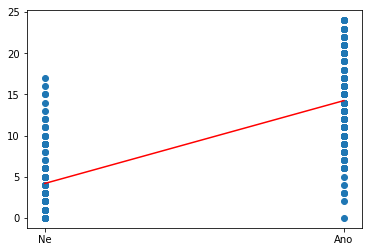

In [811]:
mw_ttest_lin_relig('REL')

Verici

--------------
Min: 17.000000
Max: 108.000000


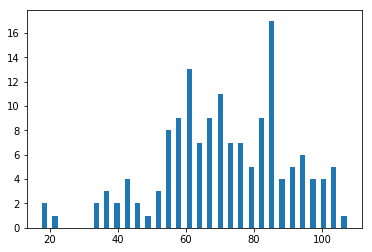

Shapiro:
  W: 0.981334
  p-value: 0.038210

Kolmogorov:
  Statistics: 0.068301
  p-value: 0.467360
--------------

Neverici

--------------
Min: 7.000000
Max: 104.000000


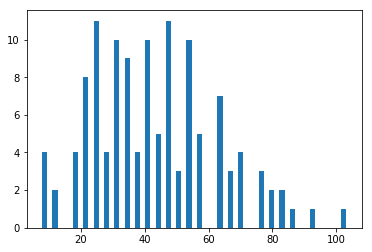

Shapiro:
  W: 0.976261
  p-value: 0.027664

Kolmogorov:
  Statistics: 0.075620
  p-value: 0.460822
--------------

Mann-Whitney:
  Stat: 2794.500000
  pvalue: 0.000000
  z: -10.007759

t-test:
  Stat: 12.263189
  pvalue: 0.000000 

KOhen's d (ttest): 1.491611

KOhen's d: 1.481965

Effect size r: -0.603491



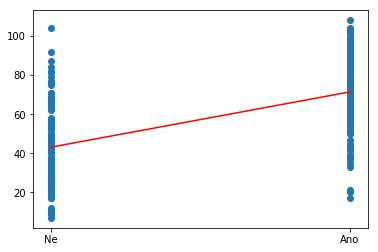

In [812]:
mw_ttest_lin_relig('CELKEM')

Pearson:
  PCC: -0.168403
  p-value: 0.005111

Spearman:
  Corr: -0.18339311450075713
  pvalue: 0.002263

Slope: -1.426880
  Intercept: 63.796090
  rvalue: -0.168403
  pvalue: 0.005111
  stderr: 0.505487



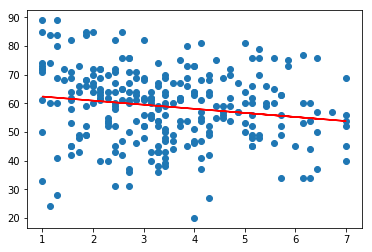

In [813]:
pearson_sperman_lin_plot('FD', u'součet')

Pearson:
  PCC: -0.073481
  p-value: 0.224505

Spearman:
  Corr: -0.08878064929399158
  pvalue: 0.141981

Slope: -0.534788
  Intercept: 60.626308
  rvalue: -0.073481
  pvalue: 0.224505
  stderr: 0.439289



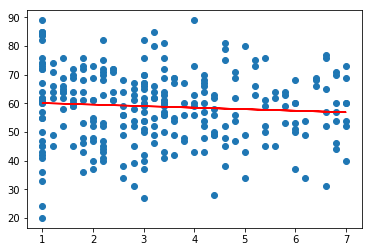

In [814]:
pearson_sperman_lin_plot('DA', u'součet')

Pearson:
  PCC: 0.120149
  p-value: 0.046527

Spearman:
  Corr: 0.10548390649464826
  pvalue: 0.080783

Slope: 1.524292
  Intercept: 49.891841
  rvalue: 0.120149
  pvalue: 0.046527
  stderr: 0.762271



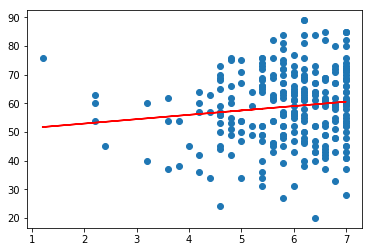

In [815]:
pearson_sperman_lin_plot('NA', u'součet')

Pearson:
  PCC: -0.005926
  p-value: 0.922075

Spearman:
  Corr: -0.0069821983362145955
  pvalue: 0.908239

Slope: -0.047724
  Intercept: 59.030885
  rvalue: -0.005926
  pvalue: 0.922075
  stderr: 0.487426



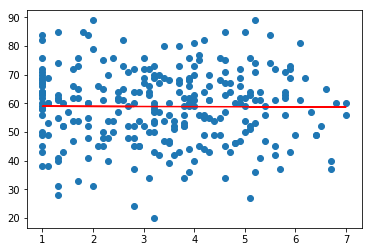

In [816]:
pearson_sperman_lin_plot('AA', u'součet')

Pearson:
  PCC: -0.302892
  p-value: 0.000000

Spearman:
  Corr: -0.3112852763394337
  pvalue: 0.000000

Slope: -2.299171
  Intercept: 66.621060
  rvalue: -0.302892
  pvalue: 0.000000
  stderr: 0.437831



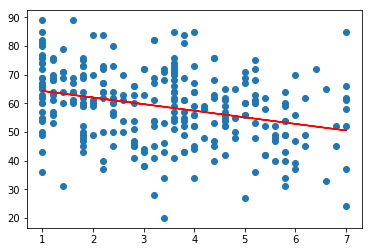

In [817]:
pearson_sperman_lin_plot('EA', u'součet')

Pearson:
  PCC: 0.148985
  p-value: 0.013391

Spearman:
  Corr: 0.15603212909035497
  pvalue: 0.009553

Slope: 0.262236
  Intercept: 55.463844
  rvalue: 0.148985
  pvalue: 0.013391
  stderr: 0.105340



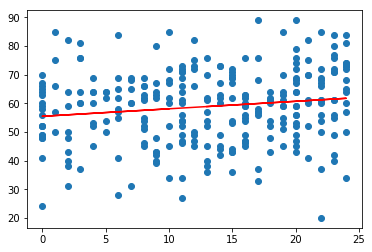

In [818]:
pearson_sperman_lin_plot('COS', u'součet')

Pearson:
  PCC: 0.081512
  p-value: 0.177718

Spearman:
  Corr: 0.0917593429774909
  pvalue: 0.129032

Slope: 0.153031
  Intercept: 57.477901
  rvalue: 0.081512
  pvalue: 0.177718
  stderr: 0.113247



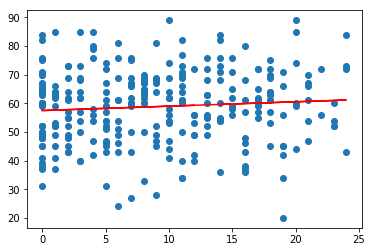

In [819]:
pearson_sperman_lin_plot('EPD', u'součet')

Pearson:
  PCC: 0.690523
  p-value: 0.000000

Spearman:
  Corr: 0.670366899923173
  pvalue: 0.000000

Slope: 1.638240
  Intercept: 33.092137
  rvalue: 0.690523
  pvalue: 0.000000
  stderr: 0.103859



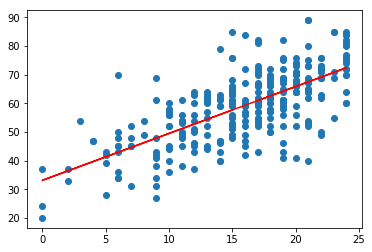

In [820]:
pearson_sperman_lin_plot('EWB', u'součet')

Pearson:
  PCC: 0.020069
  p-value: 0.740399

Spearman:
  Corr: 0.008377677044862909
  pvalue: 0.890005

Slope: 0.040884
  Intercept: 58.413418
  rvalue: 0.020069
  pvalue: 0.740399
  stderr: 0.123271



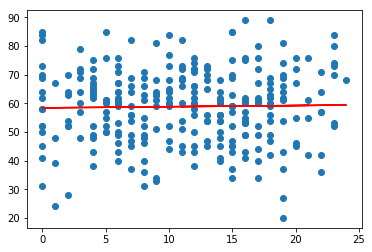

In [821]:
pearson_sperman_lin_plot('PAR', u'součet')

Pearson:
  PCC: 0.050277
  p-value: 0.406267

Spearman:
  Corr: 0.057107068663482835
  pvalue: 0.345440

Slope: 0.091003
  Intercept: 57.985867
  rvalue: 0.050277
  pvalue: 0.406267
  stderr: 0.109409



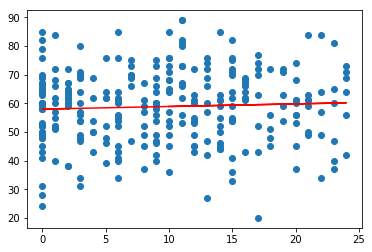

In [822]:
pearson_sperman_lin_plot('REL', u'součet')

Pearson:
  PCC: 0.248311
  p-value: 0.000031

Spearman:
  Corr: 0.23031347119273618
  pvalue: 0.000116

Slope: 0.134995
  Intercept: 50.950042
  rvalue: 0.248311
  pvalue: 0.000031
  stderr: 0.031873



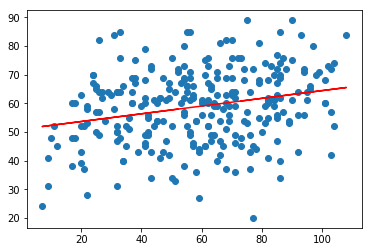

In [823]:
pearson_sperman_lin_plot('CELKEM', u'součet')

In [824]:
def construct_index(samples, sub_labels):
    levels = [samples, sub_labels]
    labels = [[], []]
    for i, v in enumerate(samples):
        for j, w in enumerate(sub_labels):
            labels[0].append(i)
            labels[1].append(j)
            
    return levels, labels

def generate_table_grouped(samples, sub_levels, group):
    results = {
        (u'N'): {},
        (u'M'): {},
        (u'SD'): {},
        (u'Min'): {},
        (u'Max'): {},
        (u'Med'): {},
        (u'k'): {},
              }
    index = [samples]

    for s in samples:
        for key, val in sub_levels.iteritems():
            results[(u'N')][(s, key)] = data.groupby(group)[s].count()[val]
            results[(u'M')][(s, key)] = data.groupby(group)[s].mean()[val]
            results[(u'SD')][(s, key)] = data.groupby(group)[s].std()[val]
            results[(u'Min')][(s, key)] = data.groupby(group)[s].min()[val]
            results[(u'Max')][(s, key)] = data.groupby(group)[s].max()[val]
            results[(u'Med')][(s, key)] = data.groupby(group)[s].median()[val]
            results[(u'k')][(s, key)] = data.groupby(group)[s].std()[val]/data.groupby(group)[s].mean()[val]
        
    pd.options.display.float_format = '{:.2f}'.format
    
    levels, labels = construct_index(samples, sub_levels.keys())
    return pd.DataFrame(results, columns=['N', 'M', 'Med', 'Min', 'Max', 'SD', 'k'], index=pd.MultiIndex(levels, labels))

In [825]:
def generate_table_all(samples):
    results = {
        (u'N'): {},
        (u'M'): {},        
        (u'SD'): {},
        (u'Med'): {},
        (u'Min'): {},
        (u'Max'): {},
        (u'k'): {}
              }

    for s in samples:
        results[(u'N')][s] = data[s].count()
        results[(u'M')][s] = data[s].mean()
        results[(u'SD')][s] = data[s].std()
        results[(u'Min')][s] = data[s].min()
        results[(u'Max')][s] = data[s].max()
        results[(u'Med')][s] = data[s].median()
        results[(u'k')][s] = data[s].std()/data[s].mean()
        
    pd.options.display.float_format = '{:.2f}'.format
    res_disp = pd.DataFrame(results, columns=['N', 'M', 'Med', 'Min', 'Max', 'SD', 'k'], index=samples)
    return res_disp

In [826]:
from collections import OrderedDict
from IPython.core.display import display, HTML
def generate_table_mw(mw_results, samples):
    results = OrderedDict()
    results['U'] = {}
    results['z'] = {}
    results['p'] = {}
    results['r'] = {}
    
    for s in samples:
        for k, v in results.items():
            results[k][s] = mw_results[s][k]

    pd.options.display.float_format = '{:.2f}'.format
    res_disp = pd.DataFrame(results, columns=results.keys(), index=samples)
    output = res_disp.to_html(formatters={
        'p': '{:,.3f}'.format,
    })
    display(HTML(output))

In [827]:
def generate_table_pearson_soucet(pearson_results, samples, b_name):
    results = OrderedDict()
    keys = ['r_s', 'p_s', 'r', 'p_p']

    for s in samples:
        for k in keys:
            if not results.get(s):
                results[s] = {}
            if k.startswith('p'):
                results[s][k] = '{:,.3f}'.format(pearson_results[(s, b_name)][k])
            else:
                results[s][k] = pearson_results[(s, b_name)][k]

    pd.options.display.float_format = '{:.2f}'.format
    res_disp = pd.DataFrame(results, columns=samples, index=keys)
    output = res_disp.to_html(formatters={
        'p': '{:,.3f}'.format,
    })
    display(HTML(output))

In [828]:
generate_table_grouped([ 'FD', 'DA', 'NA', 'AA', 'EA'], {u'Muži': u'Muž', u'Ženy': u'Žena'}, u'Pohlaví:')

N    M  Med  Min  Max   SD    k
FD Muži   93 3.10 2.86 1.00 7.00 1.55 0.50
   Ženy  182 3.63 3.43 1.00 7.00 1.47 0.40
DA Muži   93 3.09 2.80 1.00 7.00 1.79 0.58
   Ženy  182 3.39 3.20 1.00 7.00 1.75 0.52
NA Muži   93 6.06 6.40 2.20 7.00 1.13 0.19
   Ženy  182 5.80 6.00 1.20 7.00 0.94 0.16
AA Muži   93 3.01 2.70 1.00 7.00 1.75 0.58
   Ženy  182 3.58 3.70 1.00 6.80 1.48 0.41
EA Muži   93 3.30 3.20 1.00 7.00 1.87 0.57
   Ženy  182 3.41 3.40 1.00 7.00 1.60 0.47

In [829]:
generate_table_grouped(['FD', 'DA', 'NA', 'AA', 'EA'], {u'Věřící': u'Ano', u'Nevěřící': u'Ne'}, u'vira')

N    M  Med  Min  Max   SD    k
FD Nevěřící  124 3.63 3.43 1.00 7.00 1.47 0.40
   Věřící    151 3.31 3.14 1.00 7.00 1.54 0.47
DA Nevěřící  124 3.55 3.20 1.00 7.00 1.73 0.49
   Věřící    151 3.07 2.80 1.00 7.00 1.77 0.58
NA Nevěřící  124 5.77 6.00 2.20 7.00 1.05 0.18
   Věřící    151 5.98 6.20 1.20 7.00 0.97 0.16
AA Nevěřící  124 2.49 2.35 1.00 7.00 1.31 0.53
   Věřící    151 4.13 4.30 1.00 7.00 1.42 0.34
EA Nevěřící  124 3.31 3.10 1.00 7.00 1.74 0.53
   Věřící    151 3.42 3.60 1.00 7.00 1.65 0.48

In [830]:
generate_table_grouped(['CELKEM', 'COS', 'EPD', 'EWB', 'PAR', 'REL'], {u'Muži': u'Muž', u'Ženy': u'Žena'}, u'Pohlaví:')

N     M  Med  Min  Max    SD    k
CELKEM Muži   93 55.35   55   12  103 25.16 0.45
       Ženy  182 60.35   62    7  108 22.69 0.38
COS    Muži   93 12.61   13    0   24  8.01 0.63
       Ženy  182 13.18   14    0   24  6.92 0.53
EPD    Muži   93  8.35    7    0   24  7.24 0.87
       Ženy  182  9.47    9    0   24  6.62 0.70
EWB    Muži   93 16.55   18    2   24  5.27 0.32
       Ženy  182 15.32   16    0   24  5.45 0.36
PAR    Muži   93  9.20    8    0   24  6.25 0.68
       Ženy  182 12.14   13    0   23  6.11 0.50
REL    Muži   93  8.63    8    0   24  7.60 0.88
       Ženy  182 10.25   10    0   24  6.78 0.66

In [831]:
generate_table_grouped(['CELKEM', 'COS', 'EPD', 'EWB', 'PAR', 'REL'], {u'Věřící': u'Ano', u'Nevěřící': u'Ne'}, u'vira')

N     M   Med  Min  Max    SD    k
CELKEM Nevěřící  124 43.15 41.00    7  104 19.60 0.45
       Věřící    151 71.40 71.00   17  108 18.51 0.26
COS    Nevěřící  124  8.47  8.00    0   24  6.35 0.75
       Věřící    151 16.70 18.00    0   24  5.78 0.35
EPD    Nevěřící  124  6.35  5.00    0   24  6.12 0.96
       Věřící    151 11.34 11.00    0   24  6.60 0.58
EWB    Nevěřící  124 15.70 17.00    0   24  5.41 0.34
       Věřící    151 15.76 16.00    0   24  5.43 0.34
PAR    Nevěřící  124  8.45  7.50    0   23  6.20 0.73
       Věřící    151 13.36 14.00    0   24  5.49 0.41
REL    Nevěřící  124  4.18  3.00    0   17  4.32 1.04
       Věřící    151 14.25 14.00    0   24  5.53 0.39

In [832]:
generate_table_grouped([u'součet'], {u'Muži': u'Muž', u'Ženy': u'Žena'}, u'Pohlaví:')

N     M  Med  Min  Max    SD    k
součet Muži   93 61.67   62   37   89 11.17 0.18
       Ženy  182 57.44   59   20   89 13.42 0.23

In [833]:
generate_table_grouped([u'součet'], {u'Věřící': u'Ano', u'Nevěřící': u'Ne'}, u'vira')

N     M  Med  Min  Max    SD    k
součet Nevěřící  124 57.47   59   24   89 12.42 0.22
       Věřící    151 60.02   61   20   89 13.11 0.22

In [834]:
generate_table_all([ 'FD', 'DA', 'NA', 'AA', 'EA'])

,N,M,Med,Min,Max,SD,k
FD,275,3.45,3.29,1.00,7.00,1.52,0.44
DA,275,3.29,3.00,1.00,7.00,1.76,0.54
NA,275,5.89,6.00,1.20,7.00,1.01,0.17
AA,275,3.39,3.40,1.00,7.00,1.59,0.47
EA,275,3.37,3.40,1.00,7.00,1.69,0.50


In [835]:
generate_table_all(['CELKEM', 'COS', 'EPD', 'EWB', 'PAR', 'REL'])

,N,M,Med,Min,Max,SD,k
CELKEM,275,58.66,60.00,7,108,23.62,0.40
COS,275,12.99,13.00,0,24,7.30,0.56
EPD,275,9.09,8.00,0,24,6.84,0.75
EWB,275,15.73,17.00,0,24,5.41,0.34
PAR,275,11.15,12.00,0,24,6.30,0.57
REL,275,9.71,9.00,0,24,7.10,0.73


In [836]:
generate_table_all([u'součet'])

,N,M,Med,Min,Max,SD,k
součet,275,58.87,60.00,20,89,12.84,0.22


In [837]:
generate_table_mw(mw_results, ['COS', 'EPD', 'EWB', 'PAR', 'REL', 'CELKEM'])

,U,z,p,r
COS,3270.00,-9.28,0.000,-0.56
EPD,5319.00,-6.16,0.000,-0.37
EWB,9302.00,-0.09,0.464,-0.01
PAR,5127.50,-6.45,0.000,-0.39
REL,1579.00,-11.86,0.000,-0.72
CELKEM,2794.50,-10.01,0.000,-0.60


In [838]:
generate_table_pearson_soucet(pearson_results, ['FD', 'DA', 'NA', 'AA', 'EA', 'COS', 'EPD', 'EWB', 'PAR', 'REL', 'CELKEM'], u'součet')

,FD,DA,NA,AA,EA,COS,EPD,EWB,PAR,REL,CELKEM
r_s,-0.18,-0.09,0.11,-0.01,-0.31,0.16,0.09,0.67,0.01,0.06,0.23
p_s,0.002,0.142,0.081,0.908,0.000,0.010,0.129,0.000,0.890,0.345,0.000
r,-0.17,-0.07,0.12,-0.01,-0.30,0.15,0.08,0.69,0.02,0.05,0.25
p_p,0.005,0.225,0.047,0.922,0.000,0.013,0.178,0.000,0.740,0.406,0.000
